# A brief introduction to SciPy

Scipy is a collection of packages, these typically need to be imported separately:

     cluster                      : Vector Quantization / Kmeans
     fftpack                      : Discrete Fourier Transform algorithms
     integrate                    : Integration routines
     interpolate                  : Interpolation Tools
     io                           : Data input and output
     lib                          : Python wrappers to external libraries
     lib.blas                     : Wrappers to BLAS library
     lib.lapack                   : Wrappers to LAPACK library
     linalg                       : Linear algebra routines
     misc                         : Various utilities that don't have another home.
     ndimage                      : n-dimensional image package
     odr                          : Orthogonal Distance Regression
     optimize                     : Optimization Tools
     signal                       : Signal Processing Tools
     sparse                       : Sparse Matrices
     sparse.linalg                : Sparse Linear Algebra
     sparse.linalg.dsolve         : Linear Solvers
     sparse.linalg.dsolve.umfpack : :Interface to the UMFPACK library:
     sparse.linalg.eigen          : Sparse Eigenvalue Solvers
     sparse.linalg.eigen.arpack   : Eigenvalue solver using iterative methods.
     sparse.linalg.eigen.lobpcg   : Locally Optimal Block Preconditioned
                                      Conjugate Gradient Method (LOBPCG)     
     spatial                      : Spatial data structures and algorithms
     special                      : Airy Functions
     stats                        : Statistical Functions
     stats.mstats                 : Statistical functions for masked arrays
     weave                        : C/C++ integration

## Vectorizing for speed

This is silly:

In [6]:
from __future__ import absolute_import, division, print_function
import numpy as np

def dumb_myfun(a, b):
    return np.array([a[i] if a[i] < b else 2*b for i in range(len(a))])

In [7]:
x = np.arange(1.e6)/1.e6
x

array([  0.00000000e+00,   1.00000000e-06,   2.00000000e-06, ...,
         9.99997000e-01,   9.99998000e-01,   9.99999000e-01])

In [8]:
%timeit dumb_myfun(x, 0.5)

1 loop, best of 3: 412 ms per loop


We can use `scipy.vectorize`, which is similar to `map` but operates fast on numpy arrays:

In [9]:
import scipy as sp
myfun = lambda a,b: a if a < b else 2*b
vec_myfun = sp.vectorize(myfun)
vec_myfun

In [10]:
%timeit vec_myfun(x, 0.5)

1 loop, best of 3: 308 ms per loop


Let's not forget `numexpr` we saw earlier today:

In [11]:
import numexpr as ne
b = 0.5
%timeit ne.evaluate("where(x < %f, x, %f)" % (b, b*2))

100 loops, best of 3: 3.18 ms per loop


# Scipy constants

`scipy.constants` is a convenient compilation of the [2014 CODATA constants](http://physics.nist.gov/cuu/Constants/index.html).

In [16]:
from scipy import constants as cons
print(cons.milli, cons.eV, cons.c)

0.001 1.6021766208e-19 299792458.0


In [17]:
cons.physical_constants

{'Angstrom star': (1.00001495e-10, 'm', 9e-17),
 'Avogadro constant': (6.022140857e+23, 'mol^-1', 7400000000000000.0),
 'Bohr magneton': (9.274009994e-24, 'J T^-1', 5.7e-32),
 'Bohr magneton in Hz/T': (13996245042.0, 'Hz T^-1', 86.0),
 'Bohr magneton in K/T': (0.67171405, 'K T^-1', 3.9e-07),
 'Bohr magneton in eV/T': (5.7883818012e-05, 'eV T^-1', 2.6e-14),
 'Bohr magneton in inverse meters per tesla': (46.68644814,
  'm^-1 T^-1',
  2.9e-07),
 'Bohr radius': (5.2917721067e-11, 'm', 1.2e-20),
 'Boltzmann constant': (1.38064852e-23, 'J K^-1', 7.9e-30),
 'Boltzmann constant in Hz/K': (20836612000.0, 'Hz K^-1', 12000.0),
 'Boltzmann constant in eV/K': (8.6173303e-05, 'eV K^-1', 5e-11),
 'Boltzmann constant in inverse meters per kelvin': (69.503457,
  'm^-1 K^-1',
  4e-05),
 'Compton wavelength': (2.4263102367e-12, 'm', 1.1e-21),
 'Compton wavelength over 2 pi': (3.8615926764e-13, 'm', 1.8e-22),
 'Cu x unit': (1.00207697e-13, 'm', 2.8e-20),
 'Faraday constant': (96485.33289, 'C mol^-1', 0.00

In [18]:
len(cons.physical_constants)

399

We can even search it like a little database:

In [19]:
cons.find('Newton')

['Newtonian constant of gravitation',
 'Newtonian constant of gravitation over h-bar c']

In [21]:
G = cons.value('Newtonian constant of gravitation')
G_u = cons.unit('Newtonian constant of gravitation')
G_e = cons.precision('Newtonian constant of gravitation')
print('G = ', G, '+/-', G_e, G_u)

G =  6.67408e-11 +/- 4.64483494354278e-05 m^3 kg^-1 s^-2


It also provides some handy unit conversions:

In [22]:
print('32 F in K:', cons.F2K(32))
print('32 F in C:', cons.F2C(32))

32 F in K: 273.15
32 F in C: 0.0


# Interpolation

In [23]:
from scipy.interpolate import interp1d, UnivariateSpline
from scipy import constants as cons

In [28]:
# set up some fake data, listing locations versus time
rng = np.random.RandomState(42)

M = 5.98e24  # mass and radius of Earth
R = 6.38e6
accel = cons.G*M/R**2 # Earth's grav acceleration
times = np.arange(0,10,0.5) # seconds
locations = 0.5*accel*times**2 + 50*np.random.random(len(times))

# now interpolate onto a much finer grid, using both iterp1d and UnivariateSpline
i_times = np.arange(0.5,9,0.1)
# list of interpolated values of location at i_times
i_locs = interp1d(times, locations, kind="cubic")
s = UnivariateSpline(times, locations) # a function that will return interpolated values

In [29]:
%matplotlib inline
import matplotlib.pylab as plt

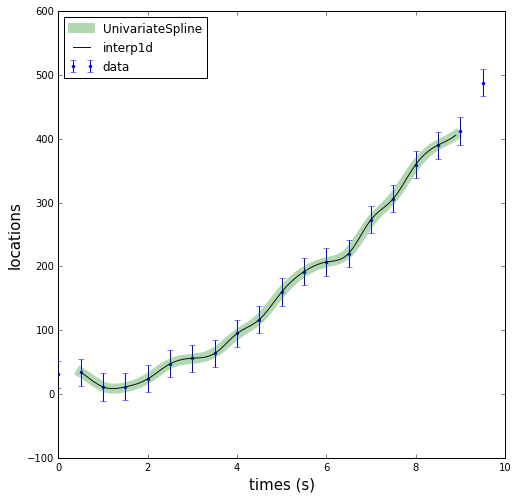

In [32]:
# plot up several different views of this example
plt.figure(figsize=(8,8))
plt.errorbar(times, locations, yerr=50/2.35, linestyle='None', marker=".", label='data')
plt.plot(i_times, s(i_times), c="g", lw=10, alpha=0.3, label='UnivariateSpline')
plt.plot(i_times, i_locs(i_times), c="black", lw=1, alpha=0.9, label='interp1d')
plt.ylabel('locations',fontsize=15)
plt.xlabel('times (s)',fontsize=15)
plt.legend(loc='best');

## Numerical Integration

In [35]:
from scipy.integrate import quad
val, err =quad( lambda x: np.sin(x) , 0 , np.pi, full_output=False)
print(val, err)

2.0 2.220446049250313e-14


In [36]:
from scipy.integrate import ode
ode?

## Special functions

In [37]:
from scipy import special
special?

In [38]:
from scipy.special import betainc
betainc(10, 10, 0.2)

0.0015791205491671057

## Polynomial Fitting

Basic (least squares) polynomial fitting can be performed using the polyfit routine. More complicated fitting tasks require scipy.

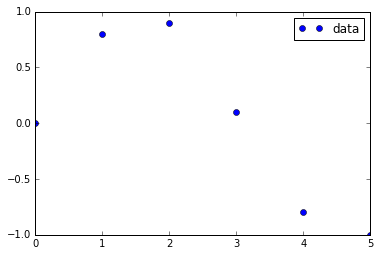

In [46]:
x = np.array([0.0, 1.0, 2.0, 3.0, 4.0, 5.0])
y = np.array([0.0, 0.8, 0.9, 0.1, -0.8, -1.0])

f, ax = plt.subplots()
ax.plot(x, y, 'o', label='data');
ax.legend();

Let's fit this data with a cubic polynomial

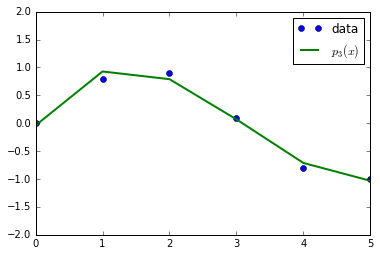

In [47]:
z = np.polyfit(x, y, 3)
p = np.poly1d(z)
ax.plot(x, p(x), '-', lw=2, label='$p_3(x)$')
ax.set_ylim(-2, 2)
ax.legend()
f

And now let' try to fit it with a degree *30* one:

/Users/jbloom/anaconda/envs/seminar/lib/python3.5/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


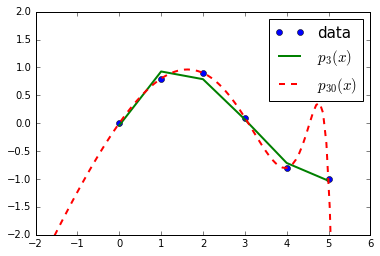

In [48]:
p30 = np.poly1d(np.polyfit(x, y, 30))
xp = np.linspace(-2, 6, 100)
ax.plot(xp, p30(xp), '--', lw=2, label='$p_{30}(x)$')
ax.legend(fontsize=15)
f

## Optimization

A simple Least Squares Fitting example. Note that in practice, you may want to choose `fmin` which provides finer control than `leastsq`.  But for simple cases `leastsq` is sufficient: 

In [50]:
from scipy.optimize import leastsq
from numpy import sin, cos, pi, sqrt

# Define a simple signal model
def model(par):
    p = 1.0 # constant frequency
    return par[0] + par[1]*sin(2*pi*t/p) + par[2]*cos(2*pi*t/p)

# Create some data with this model
par = [0.1, 1.5, 2]
t = np.linspace(0, pi, 300)
y = model(par)

# Add a bit of gaussian noise
dy = 0.5*np.random.rand(y.shape[0])
y += dy

# Define the residual function we minimize, simply the squared error
def resid(par):
    return (model(par)-y)**2

# And call leastsq for the fit (note that it returns a tuple whose first
# element is the parameter fit, what we actually want):
rez = leastsq(resid, [y.mean(), 1, 1] )[0]

print('Exact parameters: ', par)
print('Fitted parameters:', rez)

Exact parameters:  [0.1, 1.5, 2]
Fitted parameters: [ 0.34487292  1.50819851  1.99373246]


A quick visual verification:

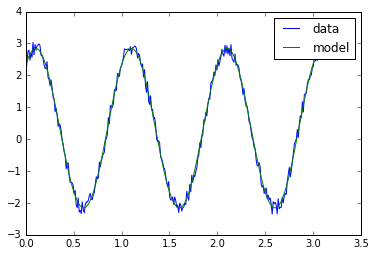

In [51]:
plt.plot(t, y, label='data')
plt.plot(t, model(rez), label='model')
plt.legend();